# 🧠 Motor Imagery Classifier — 2 Classes (Left vs Right)

**Goal:** Train and evaluate a binary MI classifier *(left-hand vs right-hand imagery)*.

---

## 🔁 Unit of Generalization

- **Unseen runs (within-subject):**  
  - Split **by run** *inside each subject*.  
  - Train on some runs, **test on held-out runs** of the **same** subject.

- **Unseen subjects (LOSO):**  
  - Split **by subject** using `GroupKFold` / `LeaveOneGroupOut`.  
  - Train on all but one subject, **test on the held-out subject**.

> Tip: Keep `X`, `y`, and `groups` aligned so that `groups` encodes **run IDs** for within-subject splits and **subject IDs** for LOSO.

---

## 📏 Evaluation Metrics

- **Accuracy** — standard proportion of correct predictions.
- **Cohen’s κ** — chance-corrected agreement (more robust under class imbalance).

> Report **mean ± SD** across folds for both metrics.

---

## ✅ Reporting Checklist

- [ ] Clearly state whether results are for **unseen runs** or **unseen subjects**.  
- [ ] Use the **same preprocessing** in train/test (fit transformers on *train only*).  
- [ ] Preserve **group boundaries** in CV splits.  
- [ ] Report **Accuracy** and **Cohen’s κ** per fold and aggregated.  
- [ ] Include **confusion matrices** (optional but helpful).

---


In [2]:
from pathlib import Path
import re, numpy as np, torch
import pandas as pd
import mne
from braindecode.models import EEGNet, ShallowFBCSPNet
from braindecode.util import set_random_seeds
from braindecode.datasets import create_from_mne_epochs
from braindecode.preprocessing import create_fixed_length_windows
from braindecode.training import CroppedLoss
from torch import nn
from torch.utils.data import DataLoader
import time

%load_ext autoreload
%autoreload 2


In [3]:
import sys, importlib.util, os
parentPath = Path.cwd().parent
sys.path.insert(0, str(parentPath))  

DATA = Path(f"{parentPath}/data")
DER  = DATA / "derivatives"  
FIGS = Path(f"{parentPath}/figs"); FIGS.mkdir(parents=True, exist_ok=True)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
mne.set_log_level("ERROR")

In [4]:
from src.utils_io import set_seeds

RUN = {
    "seed": 42,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "timestamp": time.strftime("%Y-%m-%d_%H-%M-%S"),
}

set_seeds(RUN["seed"])
print(RUN)

{'seed': 42, 'device': 'cpu', 'timestamp': '2025-10-22_19-58-48'}


In [5]:

paths = sorted(DER.glob("*-epo.fif"))
paths = [p for p in paths if re.search(r"R(04|08|12)", p.name)]  # L/R imagery only

In [6]:
list_of_epochs = []
runs, subjects = [], []
for p in paths:

    ep = mne.read_epochs(p, preload=True, verbose=False)

    if len(ep)==0: continue
    run = int(re.search(r"R(\d{2})", p.name).group(1)); runs.extend([run]*len(ep))
    subj_name = re.search(r"(S\d{3})", p.name).group(1); subj_number = int(subj_name.lstrip("S")); subjects.extend([subj_number] * len(ep))
    list_of_epochs.append(ep)
runs = np.array(runs); subjects = np.array(subjects)

In [7]:
# Load & prepare dataset for Braindecode models
n_times = len(list_of_epochs[0].times)  # samples per epoch
windows_dataset = create_from_mne_epochs(
    list_of_epochs,                 # API expects a list of Epochs
    window_size_samples=n_times,    # full-epoch window
    window_stride_samples=n_times,  # stride=length -> 1 window/epoch
    drop_last_window=True,          # drop incomplete window
)

In [8]:
X = np.stack([ds[0] for ds in windows_dataset]).astype(np.float32)   # (N, C, T)
meta = pd.concat([ds.windows.metadata for ds in windows_dataset.datasets], ignore_index=True)
y = meta["target"].to_numpy().astype(int)  # (N,)
y = np.asarray(y, dtype=np.int64).reshape(-1)   # CE loss expects int64 class indices
subjects = np.asarray(subjects, dtype=np.int32).reshape(-1)
runs     = np.asarray(runs, dtype=np.int32).reshape(-1)

# # If your labels aren’t 0..C-1, remap them safely:
# uniq = np.unique(y)
# if not np.array_equal(uniq, np.arange(uniq.size)):
#     remap = {old:i for i, old in enumerate(uniq)}
#     y = np.vectorize(remap.get, otypes=[np.int64])(y)

# # --- sanity assertions -------------------------------------------------------
# N = X.shape[0]
# assert y.shape == (N,) and subjects.shape == (N,) and runs.shape == (N,), "mismatched lengths"
# assert X.dtype == np.float32, "X must be float32"
# assert y.dtype == np.int64,   "y must be int64 for CrossEntropyLoss"
# assert subjects.dtype == np.int32 and runs.dtype == np.int32
# assert np.isfinite(X).all(), "X contains NaN/Inf"
# assert set(np.unique(y)) == set(range(np.unique(y).size)), "labels must be contiguous 0..C-1"

# --- quick summary print -----------------------------------------------------
for name, arr in {"X": X, "y": y, "subjects": subjects, "runs": runs}.items():
    print(f"{name:8s} | shape: {arr.shape}, dtype: {arr.dtype}, "
          f"min/max: {np.min(arr):.3g}/{np.max(arr):.3g}" if arr.ndim==1 else
          f"{name:8s} | shape: {arr.shape}, dtype: {arr.dtype}")


X        | shape: (1466, 64, 161), dtype: float32
y        | shape: (1466,), dtype: int64, min/max: 0/1
subjects | shape: (1466,), dtype: int32, min/max: 1/108
runs     | shape: (1466,), dtype: int32, min/max: 4/12


In [9]:
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, cohen_kappa_score
from braindecode.models import EEGNet
from braindecode.classifier import EEGClassifier
from skorch.dataset import ValidSplit
from skorch.callbacks import EarlyStopping, LRScheduler
import torch, torch.nn as nn


SFREQ = 160  # Hz
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

n_ch, n_t  = X.shape[1], X.shape[2]
n_classes  = int(np.unique(y).size)
classes_   = np.unique(y)

In [24]:
def make_eegnet(F1=8, D=2, drop=0.25):
    return EEGNet(n_chans=n_ch, n_outputs=n_classes, n_times=n_t, F1=F1, D=D, drop_prob=drop)

def make_eeg_clf(module, batch=32, epochs=30):
    return EEGClassifier(
        module=module,
        criterion=nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        batch_size=batch,
        max_epochs=epochs,
        device=DEVICE,
        train_split=ValidSplit(0.2, stratified=False, random_state=42),
        callbacks=[
            ('es', EarlyStopping(patience=5, monitor='valid_loss')),
            ('lr', LRScheduler('ReduceLROnPlateau', monitor='valid_loss', patience=3)),
        ],
        classes=classes_,
    )

def eval_with_preproc(X, y, groups, build_module, preproc_pair_fn=None, *, n_splits=5, plot_curves=False, saveFigs=False, filepath=FIGS):
    """preproc_pair_fn(X_tr, X_te) -> (X_tr_prep, X_te_prep).
       If None, identity (no preprocessing)."""
    gkf = GroupKFold(n_splits=min(n_splits, np.unique(groups).size))
    baseline_acc = []
    for fold, (tr, te) in enumerate(gkf.split(X, y, groups)):
        Xtr, Xte = X[tr], X[te]
        if preproc_pair_fn is None:
            Xtr_p, Xte_p = Xtr, Xte
        else:
            Xtr_p, Xte_p = preproc_pair_fn(Xtr, Xte)

        clf = make_eeg_clf(build_module())
        clf.fit(Xtr_p, y[tr])
        if plot_curves:
            plot_training_curves(clf, "EEGNet baseline training")
        if saveFigs:
            save_training_curves(clf, filepath=filepath, fold=fold, label="EEGNet")
        yhat = clf.predict(Xte_p)
        baseline_acc.append({
            "fold": fold,
            "acc": accuracy_score(y[te], yhat),
            "kappa": cohen_kappa_score(y[te], yhat),
        })
    return baseline_acc

def summarize(baseline_acc, label):
    acc   = np.array([r["acc"] for r in baseline_acc])
    kappa = np.array([r["kappa"] for r in baseline_acc])
    print(f"{label:30s} acc {acc.mean():.3f}±{acc.std():.3f} | κ {kappa.mean():.3f}±{kappa.std():.3f}")

import matplotlib.pyplot as plt

def plot_training_curves(clf, title="Training curves"):
    hist = clf.history
    plt.figure(figsize=(6,4))
    plt.plot(hist[:, 'train_loss'], label='Train loss')
    plt.plot(hist[:, 'valid_loss'], label='Valid loss')
    if 'valid_accuracy' in hist[0]:
        plt.plot(hist[:, 'valid_accuracy'], label='Valid acc')
    plt.xlabel("Epoch")
    plt.legend()
    plt.title(title)
    plt.show()


def save_training_curves(clf: EEGClassifier, filepath: Path, fold = None, label = "EEGNet"):
    """
    Saves training & validation loss (and accuracy if available)
    to a PNG file instead of plotting inline.
    """

    hist = clf.history
    epochs = range(1, len(hist) + 1)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(epochs, hist[:, 'train_loss'], label='Train loss', color='tab:blue')
    ax.plot(epochs, hist[:, 'valid_loss'], label='Valid loss', color='tab:orange')
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    if 'valid_accuracy' in hist[0]:
        ax2 = ax.twinx()
        ax2.plot(epochs, hist[:, 'valid_accuracy'], label='Valid acc', color='tab:green')
        ax2.set_ylabel("Accuracy")
        ax2.legend(loc='upper right')

    fname = f"{label}_fold{fold}_training_curves.png" if fold is not None else f"{label}_training_curves.png"
    filepath = Path(filepath) / fname
    plt.legend()
    plt.title(f"{label} Training curves")
    plt.tight_layout()
    plt.savefig(filepath)
    plt.close(fig)

    print(f"Training curves saved to {filepath}")

# #momo

In [ ]:
# baseline_acc = eval_with_preproc(X, y, subjects, make_eegnet, preproc_pair_fn=None, n_splits=5)
# summarize(baseline_acc, "EEGNet baseline (no preproc)")

### Test with bandpassed data

In [12]:
# def bp_8_30_pair(Xtr, Xte, l_freq=8., h_freq=30., sfreq=SFREQ):
#     # reshape to (N*C, T) for faster filtering, then back
#     def _bp(X):
#         NC, T = X.shape[0]*X.shape[1], X.shape[2]
#         X2 = np.ascontiguousarray(X.reshape(NC, T), dtype=np.float64)
#         Xf = mne.filter.filter_data(X2, sfreq=sfreq, l_freq=l_freq, h_freq=h_freq,
#                                     method='fir', verbose=False)
#         return Xf.reshape(X.shape).astype(np.float32, copy=False)
#     return _bp(Xtr), _bp(Xte)

In [13]:
# #momo
# baseline_acc_bp = eval_with_preproc(X, y, subjects, build_module=lambda: make_eegnet(),
#                             preproc_pair_fn=bp_8_30_pair, n_splits=5)
# summarize(baseline_acc_bp, "EEGNet + band-pass 8–30Hz")

In [14]:
def zscore_per_trial_pair(Xtr, Xte, eps=1e-6):
    # Best for EEGNet according to paper
    # Best for within-subject or mixed-subject
    def _z(X):
        # mean/std over time axis for each (trial, channel)
        mu  = X.mean(axis=2, keepdims=True)
        sig = X.std(axis=2, keepdims=True)
        return ((X - mu) / (sig + eps)).astype(np.float32)
    return _z(Xtr), _z(Xte)


def foldwise_channel_standardize_pair(Xtr, Xte, eps=1e-6):
    # Best for cross-subject
    # compute per-channel mean/std on TRAIN fold across trials & time
    mu  = Xtr.mean(axis=(0, 2), keepdims=True)          # (1, C, 1)
    sig = Xtr.std(axis=(0, 2), keepdims=True)           # (1, C, 1)
    def _apply(X):
        return ((X - mu) / (sig + eps)).astype(np.float32)
    return _apply(Xtr), _apply(Xte)



In [ ]:
baseline_acc_ztrial = eval_with_preproc(X, y, subjects, 
                                        build_module=lambda: make_eegnet(),
                                        preproc_pair_fn=zscore_per_trial_pair, 
                                        n_splits=5)
summarize(baseline_acc_ztrial, "EEGNet + per-trial z-score")


  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5531       0.7574        0.5021  0.0100  1.9262
      2        0.4689       0.7660        0.5252  0.0100  1.9168
      3        0.4582       0.8000        0.4499  0.0100  2.0884
      4        0.4371       0.7830        0.4615  0.0100  1.9310
      5        0.4175       0.7872        0.4804  0.0100  1.9440
      6        0.4354       0.7915        0.5420  0.0100  1.9379
      7        0.4057       0.7404        0.5121  0.0100  1.8942
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5889       0.7574        0.4863  0.0100  1.8382
      2        0.4978       0.7787        0.4394  0.0100  1.8060
      3        0.4700       0.7830        0.4379  0.0100  1.8947
      4        0.4585    

In [16]:
# baseline_acc_foldstd = eval_with_preproc(X, y, subjects, build_module=lambda: make_eegnet(),
#                                  preproc_pair_fn=foldwise_channel_standardize_pair, n_splits=5)
# summarize(baseline_acc_foldstd, "EEGNet + foldwise channel z-score")


### fine hyperparameter tuning

In [18]:
import numpy as np
import pandas as pd
from itertools import product

grid = {
    "F1":        [8, 16],
    "D":         [2, 4],
    "drop":      [0.25, 0.5],
    "epochs":    [30],      # adjust only if needed
    "batch":     [32],      # keep fixed for now to reduce variance
}

results = []
for F1, D, drop, epochs, batch in product(*grid.values()):
    rows = eval_with_preproc(
        X, y, subjects,
        build_module=lambda: make_eegnet(F1=F1, D=D, drop=drop),
        preproc_pair_fn=zscore_per_trial_pair,
        n_splits=5
    )
    accs   = [r["acc"] for r in rows]
    kappas = [r["kappa"] for r in rows]
    results.append({
        "F1": F1, "D": D, "drop": drop, "epochs": epochs, "batch": batch,
        "acc_mean": np.mean(accs), "acc_std": np.std(accs),
        "kappa_mean": np.mean(kappas), "kappa_std": np.std(kappas),
    })

tune_df = pd.DataFrame(results).sort_values("acc_mean", ascending=False).reset_index(drop=True)
display(tune_df.head(10))  # top configs
best = tune_df.iloc[0].to_dict()
print("Best (coarse):", best)


  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5569       0.7660        0.4817  0.0100  1.9890
      2        0.4756       0.7872        0.4368  0.0100  2.0357
      3        0.4673       0.7362        0.5341  0.0100  2.0435
      4        0.4553       0.7745        0.5065  0.0100  2.1147
      5        0.4362       0.7702        0.4827  0.0100  2.0817
      6        0.4335       0.7532        0.5023  0.0100  2.0348
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5645       0.7404        0.4831  0.0100  2.0352
      2        0.4961       0.7830        0.4460  0.0100  2.1041
      3        0.4822       0.7489        0.4723  0.0100  2.0080
      4        0.4570       0.7404        0.4850  0.0100  2.0557
      5        0.4463    

,F1,D,drop,epochs,batch,acc_mean,acc_std,kappa_mean,kappa_std
0,16,4,0.50,30,32,0.740826,0.040058,0.481691,0.079897
1,16,2,0.25,30,32,0.738109,0.052020,0.476108,0.103945
2,16,2,0.50,30,32,0.736746,0.048195,0.473430,0.096252
3,8,2,0.25,30,32,0.731961,0.049990,0.463416,0.100235
4,8,4,0.50,30,32,0.731276,0.040531,0.462455,0.080996
5,16,4,0.25,30,32,0.731274,0.051803,0.461913,0.104005
6,8,4,0.25,30,32,0.729245,0.050954,0.457915,0.101926
7,8,2,0.50,30,32,0.723800,0.053143,0.447058,0.106225


Best (coarse): {'F1': 16.0, 'D': 4.0, 'drop': 0.5, 'epochs': 30.0, 'batch': 32.0, 'acc_mean': 0.7408256135218594, 'acc_std': 0.0400581683342585, 'kappa_mean': 0.4816906515860769, 'kappa_std': 0.07989651534901937}


In [23]:
FIGS

PosixPath('/Users/suma/Documents/Motor-Imagery-EEG-Classifier-1/figs')

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6127       0.7532        0.4917  0.0100  4.8621
      2        0.5548       0.7702        0.4714  0.0100  4.8575
      3        0.5181       0.7787        0.4903  0.0100  5.1275
      4        0.4717       0.7617        0.4891  0.0100  5.0134
      5        0.4504       0.7532        0.5372  0.0100  4.7270
      6        0.4430       0.7404        0.5916  0.0100  4.8220
Stopping since valid_loss has not improved in the last 5 epochs.


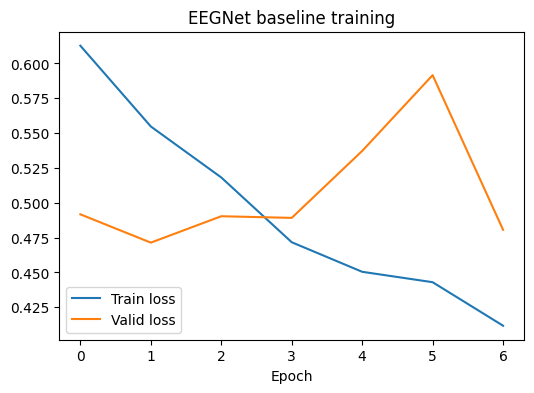

Training curves saved to /Users/suma/Documents/Motor-Imagery-EEG-Classifier-1/figs/EEGNet_fold0_training_curves.png
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6533       0.8128        0.4462  0.0100  4.7735
      2        0.5652       0.7574        0.4827  0.0100  4.6086
      3        0.5141       0.7660        0.5169  0.0100  4.6961
      4        0.4789       0.8085        0.4344  0.0100  4.7277
      5        0.4489       0.7702        0.5082  0.0100  4.4786
      6        0.4307       0.7574        0.5164  0.0100  4.7232
      7        0.4252       0.7915        0.5555  0.0100  4.7099
      8        0.4127       0.7957        0.5190  0.0100  4.7764
Stopping since valid_loss has not improved in the last 5 epochs.


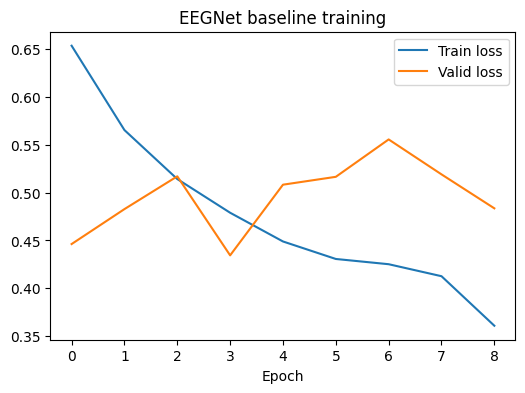

Training curves saved to /Users/suma/Documents/Motor-Imagery-EEG-Classifier-1/figs/EEGNet_fold1_training_curves.png
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6046       0.6553        0.7685  0.0100  4.9186
      2        0.5287       0.6766        0.6540  0.0100  4.6064
      3        0.4989       0.6766        0.7089  0.0100  4.7910
      4        0.4986       0.7106        0.6308  0.0100  4.7815
      5        0.4436       0.6851        0.6605  0.0100  4.7431
      6        0.4324       0.6851        0.7439  0.0100  4.6457
      7        0.4168       0.6766        0.7224  0.0100  4.7023
      8        0.4066       0.6894        0.7761  0.0100  4.6695
Stopping since valid_loss has not improved in the last 5 epochs.


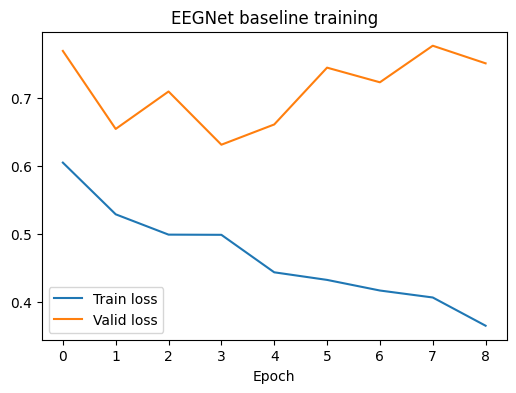

Training curves saved to /Users/suma/Documents/Motor-Imagery-EEG-Classifier-1/figs/EEGNet_fold2_training_curves.png
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6474       0.6766        0.7337  0.0100  4.7938
      2        0.5503       0.7191        0.5836  0.0100  4.9631
      3        0.5245       0.7106        0.6148  0.0100  4.8717
      4        0.4703       0.7021        0.6077  0.0100  4.7911
      5        0.4802       0.7149        0.6991  0.0100  4.8584
      6        0.4966       0.6894        0.6836  0.0100  4.6868
Stopping since valid_loss has not improved in the last 5 epochs.


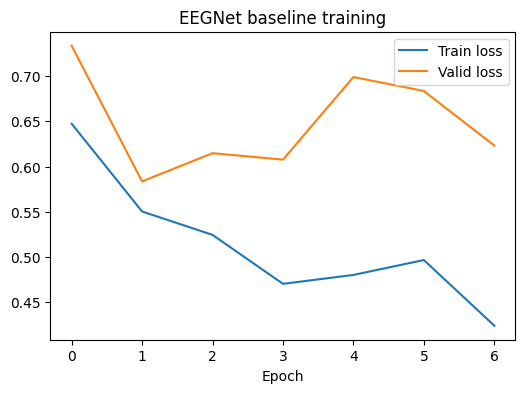

Training curves saved to /Users/suma/Documents/Motor-Imagery-EEG-Classifier-1/figs/EEGNet_fold3_training_curves.png
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6405       0.6766        0.6403  0.0100  4.8389


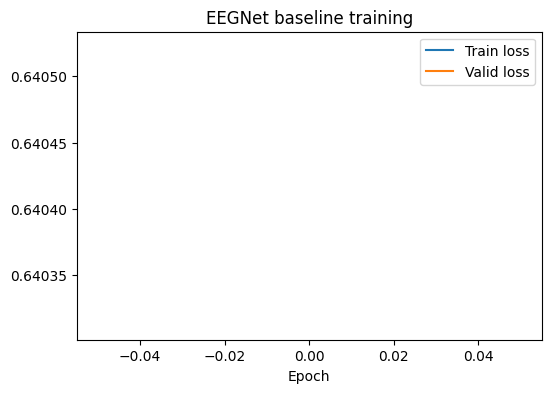

ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

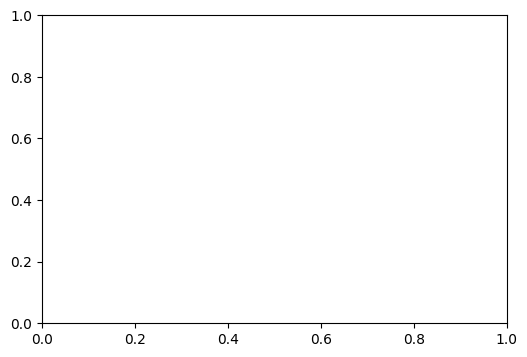

In [25]:
best_rows = eval_with_preproc(
    X, y, subjects,
    build_module=lambda: make_eegnet(F1=int(best["F1"]), D=int(best["D"]), drop=float(best["drop"])),
    preproc_pair_fn=zscore_per_trial_pair,
    n_splits=5,
    plot_curves=True,
    saveFigs=True,
    filepath=FIGS
)
summarize(best_rows, "EEGNet (best params) + per-trial z-score")


In [27]:
from sklearn.metrics import accuracy_score, cohen_kappa_score
import numpy as np
import pandas as pd

def loso_final_eval(X, y, subjects, build_module, preproc_pair_fn, label="EEGNet LOSO"):
    """
    Leave-One-Subject-Out evaluation.
    X : (N, C, T)
    y : (N,)
    subjects : (N,) array of subject IDs
    build_module : function that returns a fresh EEG model
    preproc_pair_fn : function(X_train, X_test) -> (X_train_p, X_test_p)
    """
    unique_subs = np.unique(subjects)
    rows = []

    for sub in unique_subs:
        print(f"\n🧠 Testing on subject {sub}...")
        tr_idx = np.where(subjects != sub)[0]
        te_idx = np.where(subjects == sub)[0]

        Xtr, Xte = X[tr_idx], X[te_idx]
        ytr, yte = y[tr_idx], y[te_idx]

        # preprocessing (safe: uses only train stats)
        Xtr_p, Xte_p = preproc_pair_fn(Xtr, Xte)

        # build and train
        clf = make_eeg_clf(build_module())
        clf.fit(Xtr_p, ytr)

        # predict on test subject
        yhat = clf.predict(Xte_p)
        acc = accuracy_score(yte, yhat)
        kappa = cohen_kappa_score(yte, yhat)

        rows.append(dict(sub=sub, acc=acc, kappa=kappa, n_test=len(yte)))
        print(f"   acc={acc:.3f}, κ={kappa:.3f}")

    df = pd.DataFrame(rows)
    print(f"\n{label}: acc {df.acc.mean():.3f}±{df.acc.std():.3f} | κ {df.kappa.mean():.3f}±{df.kappa.std():.3f}")
    return df


In [ ]:
# Final hold-out per subject (LOSO)
df_loso = loso_final_eval(
    X, y, subjects,
    build_module=lambda: make_eegnet(F1=8, D=2, drop=0.25),
    preproc_pair_fn=zscore_per_trial_pair,
    label="EEGNet + per-trial z-score (LOSO final test)"
)



🧠 Testing on subject 1...
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5627       0.7509        0.5254  0.0100  2.3966
      2        0.5045       0.7474        0.5130  0.0100  2.3957
      3        0.4898       0.7235        0.5444  0.0100  2.3931
      4        0.4698       0.7406        0.5290  0.0100  2.5476
      5        0.4419       0.7270        0.5649  0.0100  2.3534
      6        0.4425       0.7065        0.6060  0.0100  2.3783
Stopping since valid_loss has not improved in the last 5 epochs.
   acc=1.000, κ=1.000

🧠 Testing on subject 2...
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5663       0.7569        0.4879  0.0100  2.4632
      2        0.5162       0.7500        0.4897  0.0100  2.3281
      3        0.5141       0.7639        0.4984  0.0100  2.3431
      4       

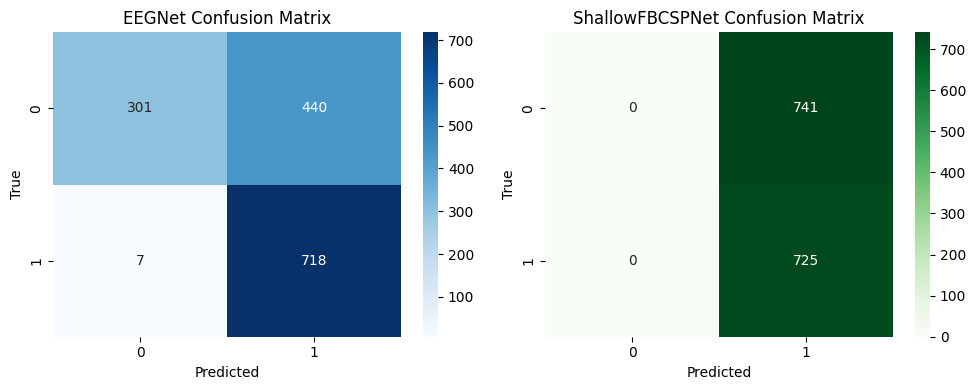

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm_eegnet = confusion_matrix(y, y_pred_eegnet)
cm_shallow = confusion_matrix(y, y_pred_shallow)
f, ax = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(cm_eegnet, annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title('EEGNet Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
sns.heatmap(cm_shallow, annot=True, fmt='d', ax=ax[1], cmap='Greens')
ax[1].set_title('ShallowFBCSPNet Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')
plt.tight_layout()
plt.show()#savefig(FIGS / "confusion_matrices.png", dpi=300)   

In [ ]:
# Visualize learned temporal kernel of EEGNet
import matplotlib.pyplot as plt
weights = clf.module_.conv_temporal.weight.detach().cpu().numpy()[0]
plt.plot(weights[0]); plt.title("Temporal kernel – EEGNet"); plt.tight_layout()
# plt.savefig("../figs/day7_eegnet_kernel.png",dpi=150)
plt.show()
